In [103]:
import pickle
import time
import re
import glob
import os
import shutil
import numpy as np
from matplotlib import pyplot
import tensorflow as tf
from nltk.corpus import stopwords
import random
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

In [5]:
def remove_stopwords(article):
    stopword_list = set(stopwords.words("english"))
    return [word for word in article.split() if word not in stopword_list]


def remove_character(article):
    return re.sub("[^a-zA-Z]+", " ", article)


def lower(string):
    return string.lower()


def clean(article):
    article = article.strip()
    article = lower(article)
    article = remove_character(article)
    article = remove_stopwords(article)
    article = ' '.join(article)
    return article

In [9]:
def create_input_count_vec(max_n_word=20000,mode_tfidf = True) : 
    
    text_train = []
    target_train = []
    text_val = []
    target_val = []
    text_test = []
    target_test = []   
    
    print('Loading and cleaning files ...')
    
    t0 = time.time()

    for link in glob.glob('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/train_list/*.txt') : 
        file = open(link,'r')
        text_train.append(clean(file.read()))
        target_train.append(int(os.path.basename(file.name)[0:2]))

        
    for link in glob.glob('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/val_list/*.txt') : 
        file = open(link,'r')
        text_val.append(clean(file.read()))
        target_val.append(int(os.path.basename(file.name)[0:2]))   

    for link in glob.glob('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/test_list/*.txt') : 
        file = open(link,'r')
        text_test.append(clean(file.read()))
        target_test.append(int(os.path.basename(file.name)[0:2]))   
        
    t1 = time.time()
    
    print('Loading and cleaning files time : ', t1-t0)
    
    print('Count Vectorization ...')
    
    if mode_tfidf == True : 
        vectorizer = TfidfVectorizer(max_features = max_n_word)
        print('mode : tdidf')
    else : 
        vectorizer = CountVectorizer(max_features = max_n_word)
        print('mode : simple count')
        
    x_train = vectorizer.fit_transform(text_train)
    y_train = np.asarray(target_train)
  
    x_val = vectorizer.transform(text_val)
    y_val = np.asarray(target_val)
    
    x_test = vectorizer.transform(text_test)
    y_test = np.asarray(target_test)
    
    t2 = time.time()
    print('Vectorization time : ', t2-t1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test

In [10]:
x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = create_input_count_vec(max_n_word=20000,mode_tfidf = True)
sets = x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test

Loading and cleaning files ...
Loading and cleaning files time :  37.14863896369934
Count Vectorization ...
mode : tdidf
Vectorization time :  19.42878794670105


## Classif

In [104]:
def run_logreg(sets) :
    x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = sets
    print('Build logistic regression model ...')
    clf = LogisticRegression(random_state=0)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    acc = accuracy_score(y_train, y_pred)
    y_pred = clf.predict(x_val)
    val_acc = accuracy_score(y_val, y_pred)
    
    print('acc :', acc)
    print('val acc :', val_acc)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    return #clf.predict_proba(np.concatenate((x_train, x_val), axis=0))[:, 1], \
           #clf.predict_proba(x_test)[:, 1], \
           #np.concatenate((y_train, y_val), axis=0) 

In [105]:
run_logreg(sets)

Build logistic regression model ...
acc : 0.9295279912184413
val acc : 0.857703081232493
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       400
           1       0.88      0.92      0.90       400
           2       0.88      0.79      0.83       185
           3       0.82      0.86      0.84       400
           4       0.79      0.79      0.79       400

    accuracy                           0.86      1785
   macro avg       0.86      0.85      0.85      1785
weighted avg       0.86      0.86      0.86      1785

[[359   4   0  19  18]
 [  3 369   1   9  18]
 [  1   2 146  20  16]
 [  7   4  12 343  34]
 [ 13  40   7  26 314]]


/Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [108]:
def run_svm(sets): 
    x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = sets
    print('Build SVM model ...')
    #[x_train, y_train, x_val, y_val, x_test, y_test] = pickle.load(open('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/dumps/'+str(num_set)+'.dat', "rb"))
    svm = LinearSVC(C=0.0001)
    svm = CalibratedClassifierCV(svm)
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_train)
    acc = accuracy_score(y_train, y_pred)
    y_pred = svm.predict(x_val)
    val_acc = accuracy_score(y_val, y_pred)

    print('acc :', acc)
    print('val acc :', val_acc)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    return #svm.predict_proba(np.concatenate((x_train, x_val), axis=0))[:, 1], \
           #svm.predict_proba(x_test)[:, 1], \
           #np.concatenate((y_train, y_val), axis=0)

In [109]:
run_svm(sets)

Build SVM model ...
acc : 0.8384193194291987
val acc : 0.8212885154061624
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       400
           1       0.84      0.91      0.87       400
           2       0.82      0.77      0.79       185
           3       0.81      0.80      0.80       400
           4       0.71      0.77      0.74       400

    accuracy                           0.82      1785
   macro avg       0.83      0.82      0.82      1785
weighted avg       0.83      0.82      0.82      1785

[[334   5   1  28  32]
 [  3 362   2   9  24]
 [  1   3 142  20  19]
 [  4   8  19 321  48]
 [ 13  51   9  20 307]]


In [110]:
def run_RandomForest(sets):
    x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = sets
    print('Build Random Forest model ...')
    #[x_train, y_train, x_val, y_val, x_test, y_test] = pickle.load(open('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/dumps/'+str(num_set)+'.dat', "rb"))
    clf = RandomForestClassifier(max_depth=3, random_state=0)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    acc = accuracy_score(y_train, y_pred)
    y_pred = clf.predict(x_val)
    val_acc = accuracy_score(y_val, y_pred)
    
    print('acc :', acc)
    print('val acc :', val_acc)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    return #clf.predict_proba(np.concatenate((x_train, x_val), axis=0))[:, 1], \
           #clf.predict_proba(x_test)[:, 1], \
           #np.concatenate((y_train, y_val), axis=0) 

In [111]:
run_RandomForest(sets)

Build Random Forest model ...
acc : 0.7054884742041713
val acc : 0.6868347338935574
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       400
           1       0.75      0.89      0.82       400
           2       1.00      0.01      0.01       185
           3       0.55      0.80      0.65       400
           4       0.61      0.51      0.56       400

    accuracy                           0.69      1785
   macro avg       0.76      0.61      0.58      1785
weighted avg       0.73      0.69      0.65      1785

[[345  10   0  29  16]
 [  3 355   0  30  12]
 [  4   5   1 116  59]
 [ 21  14   0 320  45]
 [ 24  87   0  84 205]]


## RNN

### Model 0

In [11]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [12]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(text_train)
val_dataset = tf.data.Dataset.from_tensor_slices(text_val)

In [33]:
history = model.fit(train_dataset.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=val_dataset.batch(512),
                    verbose=1)

Epoch 1/20


ValueError: in user code:

    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:541 train_step  **
        self.trainable_variables)
    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1804 _minimize
        trainable_variables))
    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1219 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['Variable:0', 'dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0'].


In [79]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

In [40]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower= True)
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 254729 unique tokens.


In [49]:
import pandas as pd

In [81]:
X = tokenizer.texts_to_sequences(text_train+text_val+text_test)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = pd.get_dummies(np.concatenate((y_train,y_val,y_test))).values
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (12680, 100)
Shape of label tensor: (12680, 5)


In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11412, 100) (11412, 5)
(1268, 100) (1268, 5)


In [67]:
print(Y_train[:10])
print(X_train[:10])

[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
[[    0     0     0 ...   208   235   668]
 [ 9341   754   614 ...  3867  1496   513]
 [   56  8459  2581 ... 15163 23410   163]
 ...
 [10050   152  2014 ...  3340 33373   415]
 [  147    72    59 ...    91  1258 25820]
 [14925  6182  1481 ...  1481   442 19636]]


### Model 1

In [83]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


### Model 2

In [97]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 20)           8880      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 105       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 5,011,465
Trainable params: 5,011,465
Non-trainable params: 0
_________________________________________________________________
None


### Model 3

In [118]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

#model = Sequential()
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 20]

### Training

In [101]:
epochs = 20
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001)])

Train on 10270 samples, validate on 1142 samples
Epoch 1/20
10270/10270 [==============================] - 19s 2ms/step - loss: 0.2146 - accuracy: 0.8863 - val_loss: 3.2340 - val_accuracy: 0.2531
Epoch 2/20
10270/10270 [==============================] - 16s 2ms/step - loss: 0.2114 - accuracy: 0.8873 - val_loss: 3.2926 - val_accuracy: 0.2592
Epoch 3/20
10270/10270 [==============================] - 16s 2ms/step - loss: 0.2078 - accuracy: 0.8879 - val_loss: 3.3671 - val_accuracy: 0.2539
Epoch 4/20
10270/10270 [==============================] - 19s 2ms/step - loss: 0.2048 - accuracy: 0.8861 - val_loss: 3.4387 - val_accuracy: 0.2513
Epoch 5/20
10270/10270 [==============================] - 16s 2ms/step - loss: 0.2031 - accuracy: 0.8870 - val_loss: 3.4128 - val_accuracy: 0.2583
Epoch 6/20
10270/10270 [==============================] - 17s 2ms/step - loss: 0.2007 - accuracy: 0.8878 - val_loss: 3.4222 - val_accuracy: 0.2601
Epoch 7/20
10270/10270 [==============================] - 15s 1ms/ste

In [58]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

911/911 [==============================] - 2s 2ms/step
Test set
  Loss: 2.092
  Accuracy: 0.215


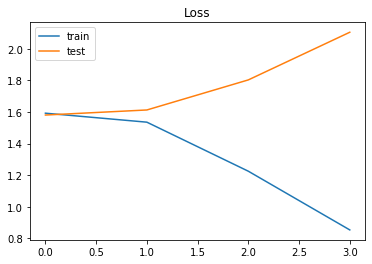

In [61]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

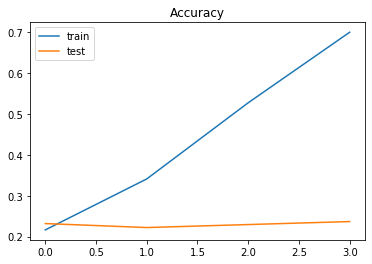

In [64]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();